# RL and ILP

## environment

In [62]:
from multi_taxi import single_taxi_v0, maps
import gymnasium as gym

from PIL import Image
def np_to_pil(img_arr):
    return Image.fromarray(img_arr)

In [63]:
single_taxi_env = single_taxi_v0.gym_env(
    num_passengers=3,
    max_fuel=50,
    has_standby_action=False,
    pickup_only=True,
    observation_type='symbolic',
    render_mode='human',
    domain_map=maps.SMALL_MAP
)

single_taxi_env = gym.wrappers.FlattenObservation(single_taxi_env)
single_taxi_env = gym.wrappers.NormalizeObservation(single_taxi_env)

In [64]:
single_taxi_env.reset()
obs, reward, term, trunc, info = single_taxi_env.step(0)
single_taxi_env.render()

print(f'reward={reward}')
print(f'term={term}')
print(f'info={info}')
print('obs={obs}')

+---------+
| : | : : |
| : | : : |
| : : : : |
|P| : | : |
|P|P: | : |
+---------+
Taxi0-YELLOW: Fuel: 49/50, Location: (4, 2), Engine: ON, Collided: False, Step: 1, ALIVE
Passenger0-YELLOW: Location: (4, 0), Destination: (-1, -1)
Passenger1-RED: Location: (3, 0), Destination: (-1, -1)
Passenger2-WHITE: Location: (4, 1), Destination: (-1, -1)
Env done: False

reward=-1
term=False
info={'events': [<Event.STEP: 1>, <Event.MOVE: 2>, <Event.HIT_OBSTACLE: 20>], 'dead': False, 'move_success': False, 'desired_action': 'south', 'performed_transition': 'south'}
obs={obs}


In [65]:
single_taxi_env.observation_space

Box(0, 1, (99,), int64)

In [66]:
single_taxi_env.unwrapped.get_observation_meanings()

['location_row',
 'location_col',
 'remaining_fuel',
 'is_dead',
 'passenger_0_location_row',
 'passenger_0_location_col',
 'passenger_0_picked_up',
 'passenger_1_location_row',
 'passenger_1_location_col',
 'passenger_1_picked_up',
 'passenger_2_location_row',
 'passenger_2_location_col',
 'passenger_2_picked_up']

In [67]:
single_taxi_env.unwrapped.get_action_meanings()

{0: 'south', 1: 'north', 2: 'east', 3: 'west', 4: 'pickup', 5: 'refuel'}

In [68]:
single_taxi_env.action_space

Discrete(6)

## ILP

### create expert agent

In [69]:
from stable_baselines3.common.vec_env import DummyVecEnv
from imitation.algorithms import bc
from imitation.algorithms.dagger import SimpleDAggerTrainer
from stable_baselines3.common.policies import BasePolicy

In [70]:
from src.decision_makers.Short_Term_Planner_DM import ST_Planner

class PlannerPolicy(BasePolicy):
    '''
    an adaptor of the bfs planner to the imitation library
    '''
    env: gym.Env
    planner = None

    def __init__(self, env, planner):
        super().__init__(env.observation_space, env.action_space)
        self.env = env
        self.planner = planner

    def _predict(self, obs, deterministic=True):
        return self.planner.get_action()


In [71]:
vec_taxi_env = DummyVecEnv([lambda: single_taxi_env])

# needs different instintiation
planner = ST_Planner(action_space=single_taxi_env.unwrapped.action_space,ma_env=single_taxi_env)
planner_policy = PlannerPolicy(single_taxi_env, planner)

/Users/ilay_menachem/miniforge3/envs/Mac_dbl/lib/python3.8/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.state to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.state` for environment variables or `env.get_wrapper_attr('state')` that will search the reminding wrappers.
  logger.warn(
/Users/ilay_menachem/miniforge3/envs/Mac_dbl/lib/python3.8/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.copy to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.copy` for environment variables or `env.get_wrapper_attr('copy')` that will search the reminding wrappers.
  logger.warn(


AttributeError: 'SingleTaxiWrapper' object has no attribute 'copy'

### dagger training

In [ ]:
import numpy as np

bc_trainer = bc.BC(
    observation_space=single_taxi_env.observation_space,
    action_space=single_taxi_env.action_space,
    rng=np.random.default_rng()
)

In [ ]:
dagger_trainer = SimpleDAggerTrainer(
    venv=vec_taxi_env,
    scratch_dir='dagger_scratch',
    expert_policy=planner_policy,
    bc_trainer=bc_trainer,
    rng=np.random.default_rng()
)

In [ ]:
dagger_trainer.train(total_timesteps=1_000_000, rollout_round_min_episodes=10)

AttributeError: 'NoneType' object has no attribute 'get_action'

### create DQN agent

In [ ]:
from stable_baselines3 import DQN

dqn_model = DQN(
    policy="MlpPolicy",
    env=single_taxi_env
)

dqn_model.policy.load_state_dict(dagger_trainer.policy.state_dict())

dqn_model.learn(total_timesteps=50000)

/Users/ilay_menachem/miniforge3/envs/Mac_dbl/lib/python3.8/site-packages/stable_baselines3/common/buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 550.72GB > 3.65GB
  warnings.warn(


RuntimeError: Error(s) in loading state_dict for DQNPolicy:
	Missing key(s) in state_dict: "q_net.q_net.0.weight", "q_net.q_net.0.bias", "q_net.q_net.2.weight", "q_net.q_net.2.bias", "q_net.q_net.4.weight", "q_net.q_net.4.bias", "q_net_target.q_net.0.weight", "q_net_target.q_net.0.bias", "q_net_target.q_net.2.weight", "q_net_target.q_net.2.bias", "q_net_target.q_net.4.weight", "q_net_target.q_net.4.bias". 
	Unexpected key(s) in state_dict: "mlp_extractor.policy_net.0.weight", "mlp_extractor.policy_net.0.bias", "mlp_extractor.policy_net.2.weight", "mlp_extractor.policy_net.2.bias", "mlp_extractor.value_net.0.weight", "mlp_extractor.value_net.0.bias", "mlp_extractor.value_net.2.weight", "mlp_extractor.value_net.2.bias", "action_net.weight", "action_net.bias", "value_net.weight", "value_net.bias". 

In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy

mean_reward, std_reward = evaluate_policy(dqn_model, single_taxi_env, n_eval_episodes=10)
print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

dqn_model.save("dqn_dagger_single_taxi")

## RL

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np

from stable_baselines3 import A2C, DQN
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy

In [ ]:
log_dir = "temp/"
os.makedirs(log_dir, exist_ok=True)

In [ ]:
single_taxi_env = Monitor(single_taxi_env, log_dir)
eval_callback = EvalCallback(single_taxi_env, best_model_save_path=log_dir, log_path=log_dir, eval_freq=1000, deterministic=True, render=False)
checkpoint_callback = CheckpointCallback(save_freq=50000, save_path=log_dir)

#agent = A2C(policy='MlpPolicy', env=single_taxi_env, verbose=0, gamma=0.99, n_steps=5, learning_rate=0.0007)
agent = DQN(policy='MlpPolicy', env=single_taxi_env, verbose=0, gamma=0.95, batch_size=128, exploration_final_eps=0.1, exploration_fraction=0.9)

ValueError: You must use `MultiInputPolicy` when working with dict observation space, not MlpPolicy

In [ ]:
def eval_policy(agent, env, n_eval_episodes=10):
    mean_reward, std_reward = evaluate_policy(agent, env, n_eval_episodes=10)
    print(f'mean_reward={mean_reward:.2f} +/- {std_reward:.2f}')

eval_policy(agent, single_taxi_env)

mean_reward=-137.90 +/- 31.00


In [ ]:
agent.learn(total_timesteps=250_000, callback=[eval_callback, checkpoint_callback])

KeyboardInterrupt: 

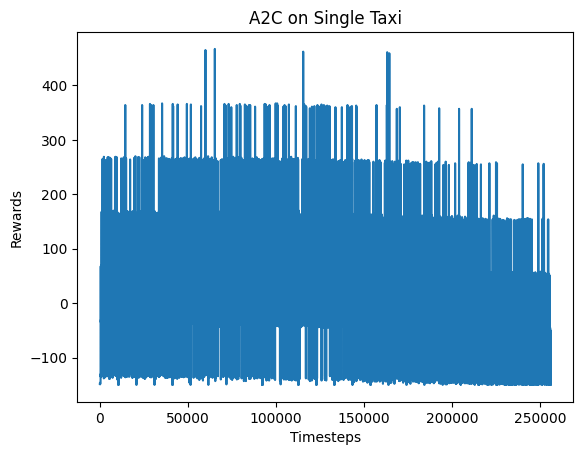

In [ ]:
results = load_results(log_dir)
x, y = ts2xy(results, 'timesteps')

plt.plot(x, y)
plt.xlabel('Timesteps')
plt.ylabel('Rewards')
plt.title('Single Taxi')
plt.show()

In [ ]:
import time
from IPython.display import clear_output

def sample_trajectory(env, agent):
    obs = env.reset()[0]

    for _ in range(100):
        action, _ = agent.predict(obs)
        obs, _, done, _, _ = env.step(int(action))

        if done:
            break

        print(env.render())
        time.sleep(0.1)
        clear_output(wait=True)

sample_trajectory(single_taxi_env, agent)

+---------+
| : : : : |
| : :P: :P|
| : : : : |
| : : : : |
|P: : : : |
+---------+
Taxi0-YELLOW: Fuel: 2/50, Location: (4, 4), Engine: ON, Collided: False, Step: 32, ALIVE
Passenger0-YELLOW: Location: (1, 4), Destination: (-1, -1)
Passenger1-RED: Location: (4, 0), Destination: (-1, -1)
Passenger2-WHITE: Location: (1, 2), Destination: (-1, -1)
Env done: False

None
